In [1]:
import vnquant.data as dt
from vnquant import plot as pl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

import numpy as np
import pandas as pd
import math

import sys
sys.path.append('E:/Visual studio project/Arimax')

from arima.utils import*

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from tqdm import tqdm

In [2]:
stock= SelectedStock("VCB", "2020-01-01", "2023-01-01")
stock.data = stock.data.droplevel(level='Symbols', axis=1)

2023-12-04 13:32:12,121 : INFO : data VCB from 2020-01-01 to 2023-01-01 have already cloned!


In [3]:
df = stock.data
df.interpolate(method='quadratic', limit_direction='forward',limit_area='inside', axis=0, inplace=True)
df , i = remove_outliers_IQR(df,"close",4)

training_data_len = math.ceil(len(df) * .9)
training_data_len
 

train_data = df[:training_data_len].iloc[:,3:4]
test_data = df[training_data_len:].iloc[:,3:4]
print(train_data.shape, test_data.shape)

Đã loại bỏ 0 phần tử
(985, 1) (109, 1)


In [4]:
dataset_train = train_data.close.values
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(985, 1)

In [5]:
# Selecting Open Price values
dataset_test = test_data.close.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(109, 1)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
 
print(scaled_train[:5])

scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[[0.56756757]
 [0.55236486]
 [0.5344399 ]
 [0.51617057]
 [0.51182432]]
[0.63339179] [0.62194495] [0.65628547] [0.68681037] [0.68290613]


In [7]:
sequence_length = 50  
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([935, 50, 1]), torch.Size([935, 50, 1]))

In [8]:
sequence_length = 30  
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([79, 30, 1]), torch.Size([79, 30, 1]))

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


e:\Program Files\Python310\lib\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
batch_size = 16

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
num_epochs = 50
train_hist =[]
test_hist =[]

for epoch in range(num_epochs):
	total_loss = 0.0

	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)
	torch.save(model.state_dict(), 'lstm_model_fpt.pth')

	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0016, Test Loss: 0.0066
Epoch [20/50] - Training Loss: 0.0007, Test Loss: 0.0030
Epoch [30/50] - Training Loss: 0.0006, Test Loss: 0.0028
Epoch [40/50] - Training Loss: 0.0006, Test Loss: 0.0028
Epoch [50/50] - Training Loss: 0.0006, Test Loss: 0.0028


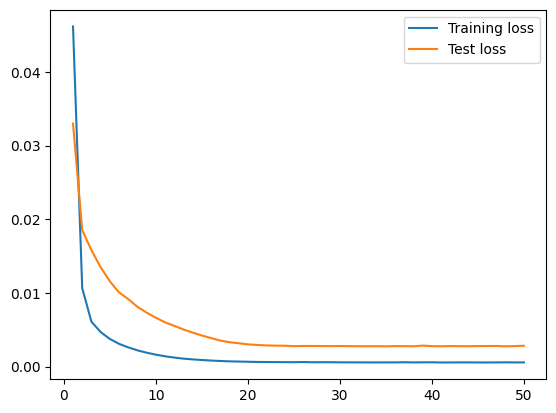

In [14]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [15]:

num_forecast_steps = 30
 
sequence_to_plot = X_test.squeeze().cpu().numpy()
 
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
forecasted_values = []

with torch.no_grad():
    for _ in range(num_forecast_steps):

        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)

        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        forecasted_values.append(predicted_value[0])
 
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
 
last_date = test_data.index[79]
 
future_dates = pd.date_range(start=last_date-pd.DateOffset(days=1) , periods=30)
 
combined_index = test_data.index.append(future_dates)

(30,)


E:\User Data\ipykernel_14736\530666668.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


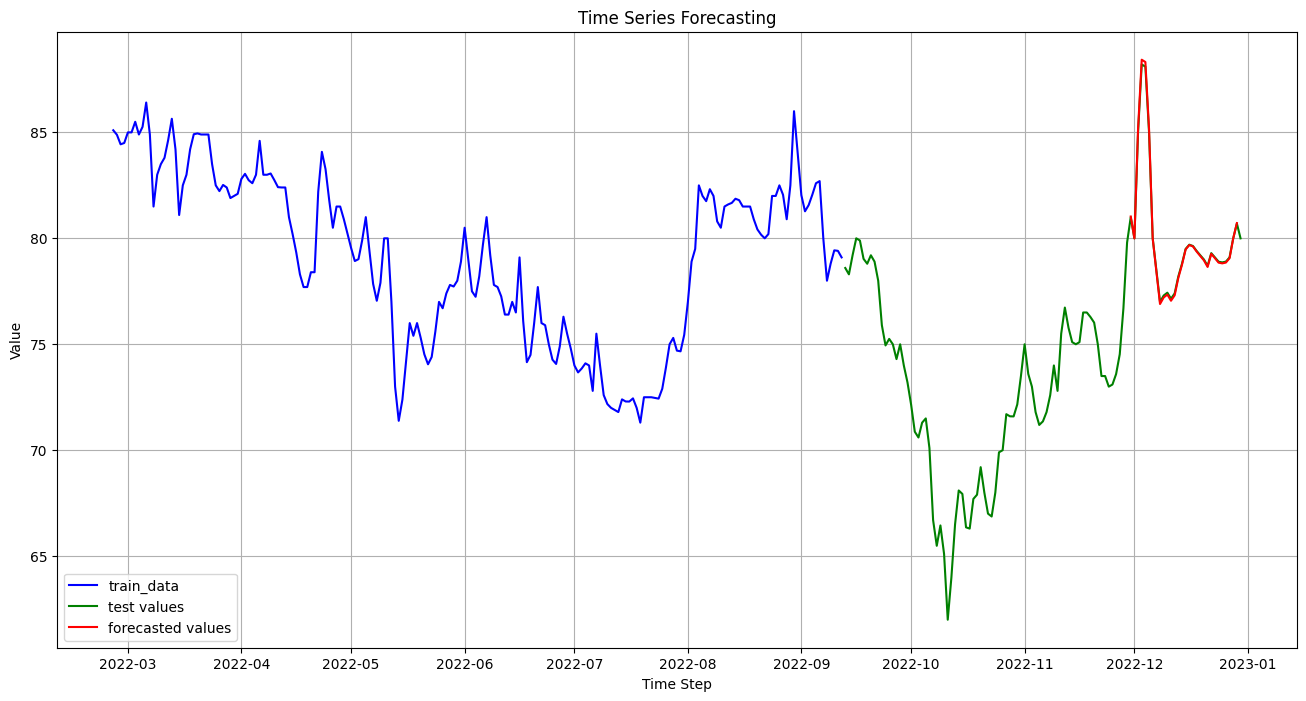

In [16]:
plt.rcParams['figure.figsize'] = [16, 8] 
 
plt.plot(train_data.index[-200:], train_data[-200:], label = "train_data", color = "b") 
 
plt.plot(test_data.index[:], test_data, label='test values', color='green') 
 

forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 

plt.plot(combined_index[-30:], forecasted_cases, label='forecasted values', color='red')  
 
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

In [17]:
result_close_df = evaluate_model( test_data[78:108], forecasted_cases)
print(result_close_df)

      Metric     Value
0        MSE  0.007475
1        MAE  0.064600
2       RMSE  0.086457
3  R-squared  0.999062
